<a href="https://colab.research.google.com/github/mohiteprathamesh1996/Predicting-the-onset-of-diabetes-based-on-diagnostic-measures/blob/main/PIMA_Indians_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center"> Diabetes Classification using Sklearn Pipeline

#### Load packages

In [1]:
import pandas as pd
pd.options.display.max_rows = 999
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, recall_score

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

#### Load data

In [2]:
df_diabetes = pd.read_csv("https://raw.githubusercontent.com/krishnaik06/Diabetes-Prediction/master/data/pima-data.csv")

df_diabetes.head()

,num_preg,glucose_conc,diastolic_bp,thickness,insulin,bmi,diab_pred,age,skin,diabetes
0,6,148,72,35,0,33.6,0.627,50,1.3790,True
1,1,85,66,29,0,26.6,0.351,31,1.1426,False
2,8,183,64,0,0,23.3,0.672,32,0.0000,True
3,1,89,66,23,94,28.1,0.167,21,0.9062,False
4,0,137,40,35,168,43.1,2.288,33,1.3790,True


#### Exploring data distribution

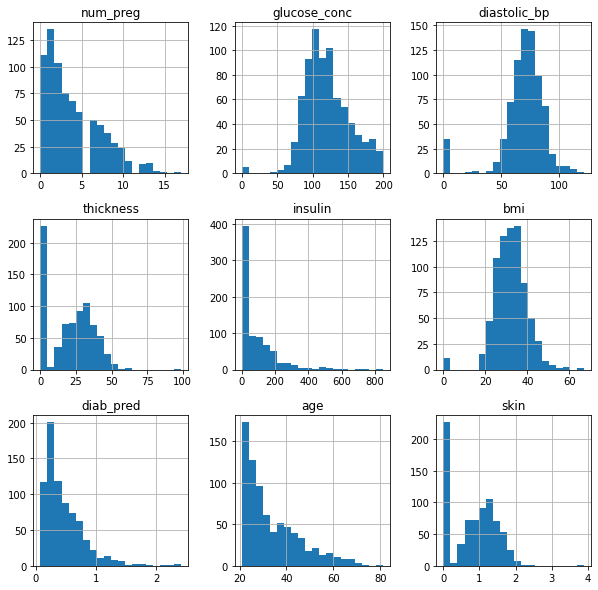

In [3]:
df_diabetes[[i for i in df_diabetes.columns \
             if df_diabetes[i].dtypes==int or df_diabetes[i].dtypes==float]]\
             .hist(figsize=(10,10), bins=20) 

plt.show()

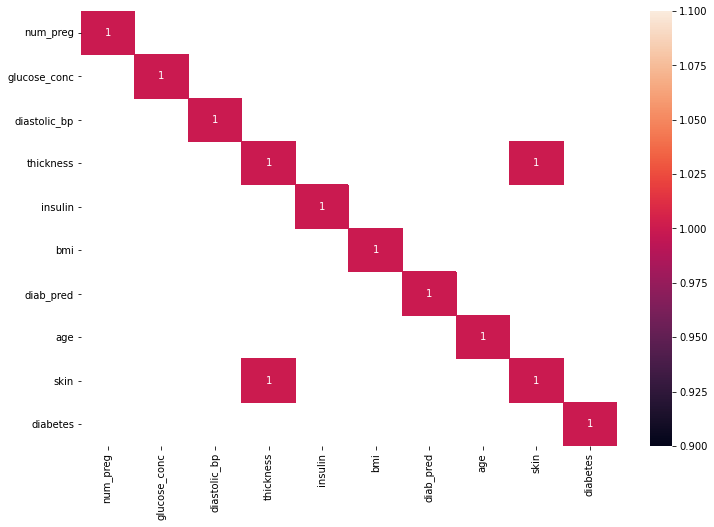

In [4]:
plt.rcParams["figure.figsize"] = (12, 8)

sns.heatmap(df_diabetes.corr().abs()[(df_diabetes.corr().abs()>0.75) |
                                     (df_diabetes.corr().abs()==1)], 
            annot=True)

plt.show()

In [5]:
df_diabetes["diabetes"] = df_diabetes["diabetes"].map({True:1, False:0})

#### Split training and test data

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_diabetes.drop(columns=["diabetes"]),
                                                    df_diabetes["diabetes"],
                                                    test_size=0.20,
                                                    random_state=42)

#### Fixing class imbalance in training dataset

In [7]:
print("Training data class imbalance is as follows: \n",y_train.value_counts())

from imblearn.over_sampling import SMOTE

os = SMOTE()

X_train_resampled, y_train_resampled = os.fit_resample(X_train, y_train)

print("\nAfter oversampling: \n", pd.Series(y_train_resampled).value_counts())

Training data class imbalance is as follows: 
 0    401
1    213
Name: diabetes, dtype: int64

After oversampling: 
 1    401
0    401
dtype: int64


#### Create pipeline¶
##### Step 1: Data Preprocessing and scaling (mean=0, SD=1)
##### Step 2: Dimensionality reduction using Principal Component Analysis
##### Step 3: Fit model

In [8]:
# Number of PCs
pcs = 2

# Define pipeline for Logistic Regression classifier
lr_pipeline = Pipeline([("Scaling_1", StandardScaler()),
                        ("Dim_Red_1", PCA(n_components=pcs)),
                        ("LogRegClass", LogisticRegression())])

# Define pipeline for Decision Tree classifier
dtree_pipeline = Pipeline([("Scaling_2", StandardScaler()),
                           ("Dim_Red_2", PCA(n_components=pcs)),
                           ("DecisionTreeClass", DecisionTreeClassifier())])

# Define pipeline for Random Forest classifier
RF_pipeline = Pipeline([("Scaling_3", StandardScaler()),
                        ("Dim_Red_3", PCA(n_components=pcs)),
                        ("RandomForestClass", RandomForestClassifier())])

# Define pipeline for KNN classifier
KNN_pipeline = Pipeline([("Scaling_4", StandardScaler()),
                         ("Dim_Red_4", PCA(n_components=pcs)),
                         ("KNN_Class", KNeighborsClassifier())])

# Define pipeline for Gradient boosting classifier
GBoost_pipeline = Pipeline([("Scaling_5", StandardScaler()),
                            ("Dim_Red_5", PCA(n_components=pcs)),
                            ("GradientBoostingClass", GradientBoostingClassifier())])


# Create list of all above pipelines
concat_pipelines = [lr_pipeline, dtree_pipeline, RF_pipeline, KNN_pipeline, GBoost_pipeline]

#### Base Model fitting

In [9]:
# Fit each model in the pipeline on the training data
for model in tqdm(concat_pipelines):
  model.fit(X_train_resampled, y_train_resampled)

# Best performance on test data
leaderboard = pd.DataFrame([(model.steps[2][0], 
                             model.score(X_train_resampled, y_train_resampled),
                             model.score(X_test, y_test),
                             recall_score(y_test, model.predict(X_test)),
                             model) for model in concat_pipelines], 
                           columns=["Algorithm", "Training Accuracy", "Validation Accuracy", "Recall", "FittedModel"])\
                           .sort_values(by=["Validation Accuracy"], ascending=False)\
                           .reset_index(drop=True)

leaderboard.head()

100%|██████████| 5/5 [00:00<00:00, 11.61it/s]


,Algorithm,Training Accuracy,Validation Accuracy,Recall,FittedModel
0,DecisionTreeClass,1.000000,0.668831,0.709091,"(StandardScaler(copy=True, with_mean=True, wit..."
1,LogRegClass,0.690773,0.662338,0.690909,"(StandardScaler(copy=True, with_mean=True, wit..."
2,RandomForestClass,1.000000,0.636364,0.690909,"(StandardScaler(copy=True, with_mean=True, wit..."
3,GradientBoostingClass,0.850374,0.629870,0.745455,"(StandardScaler(copy=True, with_mean=True, wit..."
4,KNN_Class,0.809227,0.590909,0.690909,"(StandardScaler(copy=True, with_mean=True, wit..."


#### Hyperparameter tuning

In [10]:
# Create grid of parameters for all models
param_grid = {"LogRegClass" : {"LogRegClass__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                               "LogRegClass__penalty": ['l1', 'l2'],
                               "LogRegClass__max_iter": list(range(100,800,100)),
                               "LogRegClass__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
              
              "DecisionTreeClass" : {'DecisionTreeClass__max_depth': np.arange(3, 20)},
              
              "GradientBoostingClass" : {'GradientBoostingClass__max_depth': np.arange(3, 20)},
              
              "KNN_Class" : {"KNN_Class__algorithm" : ["auto", "ball_tree", "kd_tree", "brute"],
                             "KNN_Class__n_neighbors" : np.arange(3, 50)},
              
              "RandomForestClass" : {'RandomForestClass__max_features' : ["auto", "sqrt", "log2"],
                                     'RandomForestClass__min_samples_split' : np.linspace(0.1, 1.0, 10),
                                     'RandomForestClass__max_depth' : [x for x in range(5,20)]}}

In [11]:
# Fitting the best tuned model 
algo = []
tr_acc = []
val_acc = []
rec = []
fitted = []

for model in tqdm(concat_pipelines):
  scoring_metrics = make_scorer(score_func=recall_score, greater_is_better=True)
  
  gridsearched = GridSearchCV(model, param_grid[model.steps[2][0]], scoring=scoring_metrics, cv=5)
  
  gridsearched.fit(X_train_resampled, y_train_resampled)

  algo.append(model.steps[2][0])

  tr_acc.append(gridsearched.score(X_train_resampled, y_train_resampled))

  val_acc.append(gridsearched.score(X_test, y_test))

  rec.append(recall_score(y_test, gridsearched.predict(X_test)))

  fitted.append(gridsearched)

100%|██████████| 5/5 [08:31<00:00, 102.21s/it]


In [12]:
# Print leaderboard
tuned_leaderboard = pd.DataFrame([algo, tr_acc, val_acc, rec, fitted], 
                                 index=["Algorithm", "Training Accuracy", "Validation Accuracy", "Recall", "FittedModel"]).T\
                                    .sort_values(by=["Recall"], ascending=False)\
                                    .reset_index(drop=True)

tuned_leaderboard

,Algorithm,Training Accuracy,Validation Accuracy,Recall,FittedModel
0,RandomForestClass,1,1,1,"GridSearchCV(cv=5, error_score=nan,\n ..."
1,GradientBoostingClass,0.950125,0.781818,0.781818,"GridSearchCV(cv=5, error_score=nan,\n ..."
2,KNN_Class,0.783042,0.745455,0.745455,"GridSearchCV(cv=5, error_score=nan,\n ..."
3,DecisionTreeClass,0.755611,0.690909,0.690909,"GridSearchCV(cv=5, error_score=nan,\n ..."
4,LogRegClass,0.683292,0.636364,0.636364,"GridSearchCV(cv=5, error_score=nan,\n ..."
